# TODO  checkout why y does not fit properly and samping fails etc.

In [ ]:
#%pip install jupyter
# TODO check out hwy y doe snot fit correclty

In [2]:
#%pip install -i https://test.pypi.org/simple --extra-index-url https://pypi.org/simple tramdag

In [3]:
import os
from tramdag import TramDagModel, TramDagConfig

In [4]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='exp/', experiment_name='dumm1') # works also without arguments, then default paths are used

Configuration already exists: exp/configuration.json


In [5]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'T':'continous', 
            'x2':'continous',
            'y':'continous'} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
T                    | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
y                    | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at exp/configuration.

/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


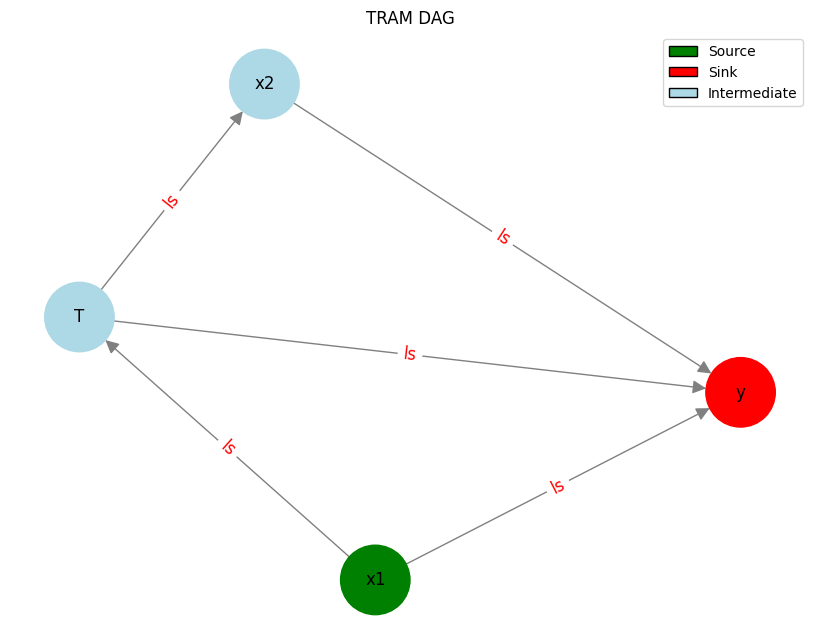

In [6]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

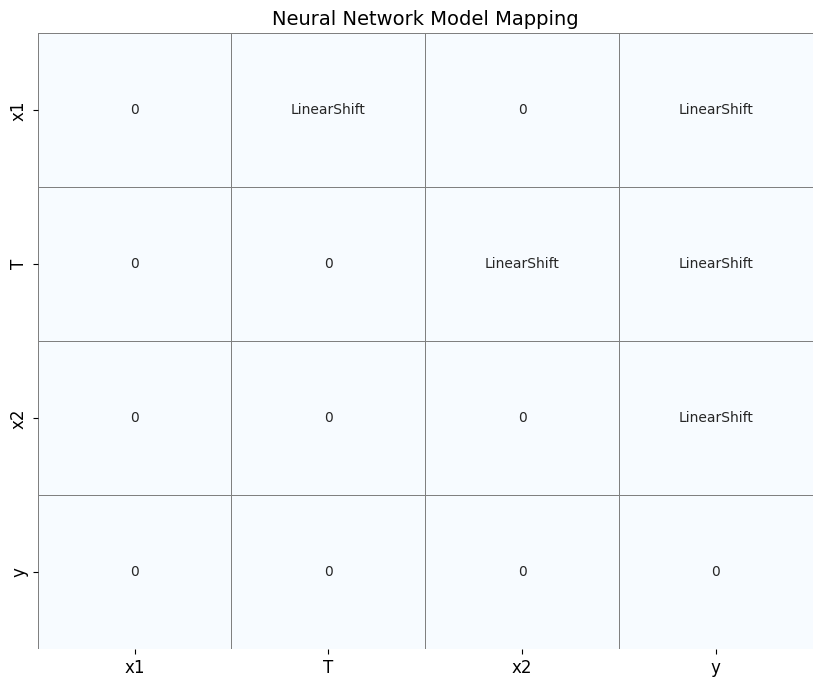

In [7]:
cfg.set_tramdag_nn_models() 
#Create the NN models one per node
# Create names for the models, which then can be to define different architectures for different nodes

All is in the configuration file now, so we delete cfg and load the configuration file

In [8]:
cfg = TramDagConfig.load_json('exp/configuration.json')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np


# Ja, sag mal, X1 ist uniform verteilt zwischen 0 und 2.
# T Modelliert als logistische Regression in Abhängigkeit von x1 mit dem Koeffizienten 2. 
# x2 ist normalverteilt mit Mittelwert 0 und Standardabweichung 1.
n = 10_000    
x1 = np.random.uniform(0, 2, size=(n, 1))
T = np.random.binomial(1, 1 / (1 + np.exp(-2 * x1)))
x2 = -1*T + np.random.normal(0,0.1, size=(n, 1))
y = 4*T + 2*x2 + 3*x1 + np.random.normal(0, 0.1, size=(n, 1))
df = pd.DataFrame({'x1': x1.flatten(), 'T': T.flatten(), 'x2': x2.flatten(), 'y': y.flatten()})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  T        x2         y
0  0.900709  1 -1.065982  4.632528
1  1.715781  1 -0.956834  7.279623
2  1.457727  1 -1.201399  6.132805
3  1.418130  0  0.064378  4.471044
4  0.110868  0  0.011848  0.457374


In [10]:
from tramdag import TramDagModel
#cfg.compute_levels(train_df) #Calculate the levels from the training file


$$
u2 = h(x2|T=1)
$$

$$
x2 = h^{-1}(u2|T=1)
$$

$$
x2 = h^{-1}(h(x2|T=1)|T=1)
$$


$$
uy = h(y|T=1, x1,x2) \\
y = h^{-1}(uy|T=1, x1,x2) \\
y = h^{-1}(h(y|T=1, x1,x2)|T=1, x1,x2)

$$

In [11]:
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device)
# Created the model from the configuration
# If weight initialization is set to True then R code like Polar... is used to initialize the weights

In [22]:
epochs = 1000
td_model.fit(train_df, val_df,
             # train_list=['target'], #Training only on a subset of the model
             learning_rate=1e-2,
             epochs=epochs,batch_size=1000,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,       #For DataLoader
             train_mode = "sequential") #Parallel is better for many nodes


[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp/min_max_scaling.json
[INFO] Training 4 nodes (sequential) on cpu

[INFO] Training node 'x1' for 1000 epochs on cpu (pid=1034461)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'T' for 1000 epochs on cpu (pid=1034461)
[INFO] Existing model found. Loading weights and history from LAST model...

===== Epoch 791/1000 =====


[INFO] Saved linear shift weights for epoch 791 -> exp/T/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 791 -> exp/T/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 791: Train NLL=-2.0352 | Val NLL=-2.0324 | Time=0.68s

===== Epoch 792/1000 =====
[INFO] Saved linear shift weights for epoch 792 -> exp/T/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 792 -> exp/T/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 792: Train NLL=-2.0360 | Val NLL=-2.0331 | Time=0.25s

===== Epoch 793/1000 =====
[INFO] Saved linear shift weights for epoch 793 -> exp/T/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 793 -> exp/T/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 793: Train NLL=-2.0367 | Val NLL=-2.0338 | Time=0.26s

===== Epoch 794/1000 =====
[INFO] Saved linear shift weights for epoch 794 -> exp/T/linear_shifts_all_epochs.

[INFO] Loaded training/validation histories for 4 nodes.


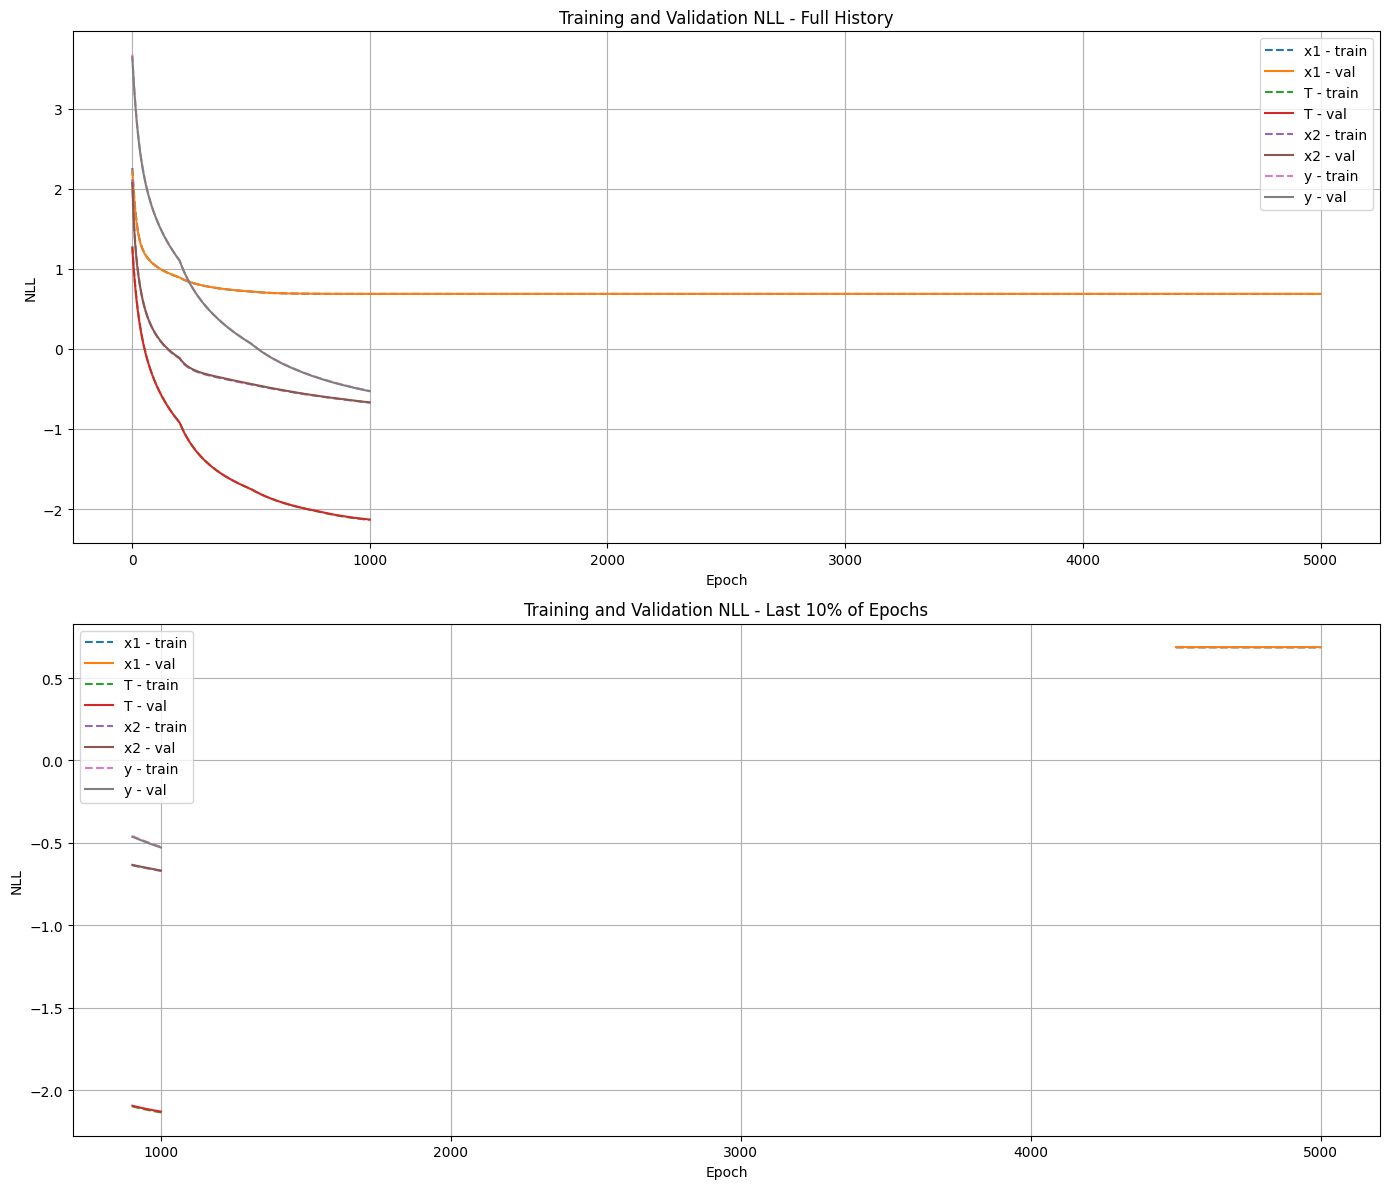

In [23]:
td_model.plot_loss_history()

In [33]:
#td_model.plot_linear_shift_history(ref_lines={'x2':[1.973827],'x2':[-0.1815344, -1.0012274 ]})

In [34]:
## td_model.linear_shift_history()

In [35]:
#td_model.plot_simple_intercepts_history(ref_lines={'x1':[-1.998953,  0.426397,  1.032376]})

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Deleted directory: exp/x1/sampling
Deleted directory: exp/T/sampling
Deleted directory: exp/x2/sampling
Deleted directory: exp/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[INFO] Loaded best model weights for node 'x1' from exp/x1/best_model.pt
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.61it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node T from standard logistic distribution
[INFO] Loaded best model weights for node 'T' from exp/T/best_model.pt
[WARNING] target_col 'T' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.08it/s]

[INFO] Completed sampling for node 'T'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[INFO] Loaded best model weights for node 'x2' from exp/x2/best_model.pt
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 46.19it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node y from standard logistic distribution
[INFO] Loaded best model weights for node 'y' from exp/y/best_model.pt
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.74it/s]


[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


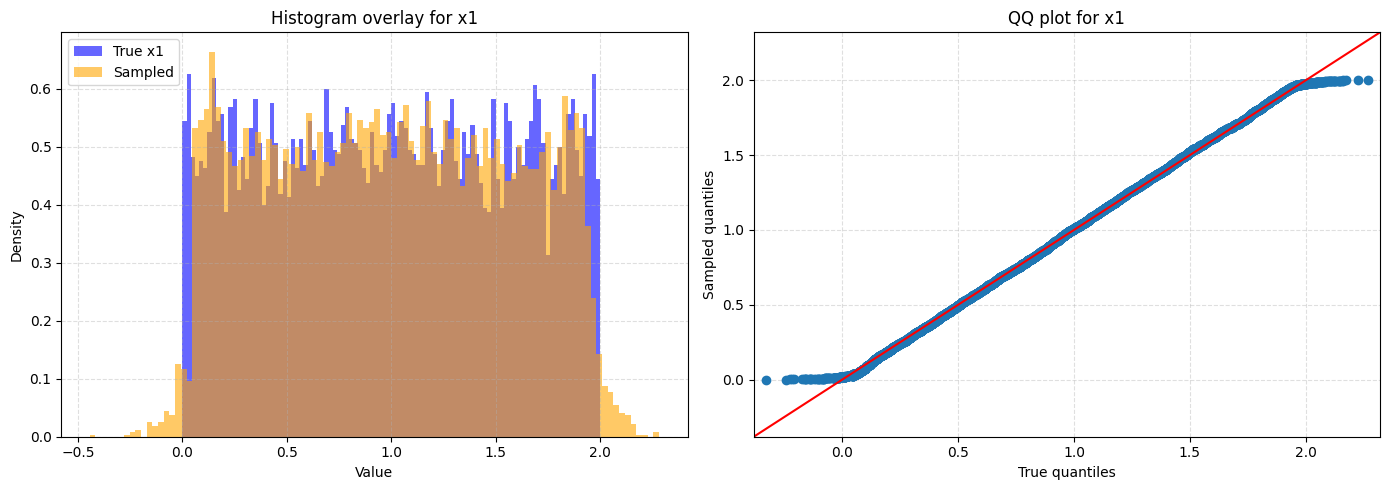

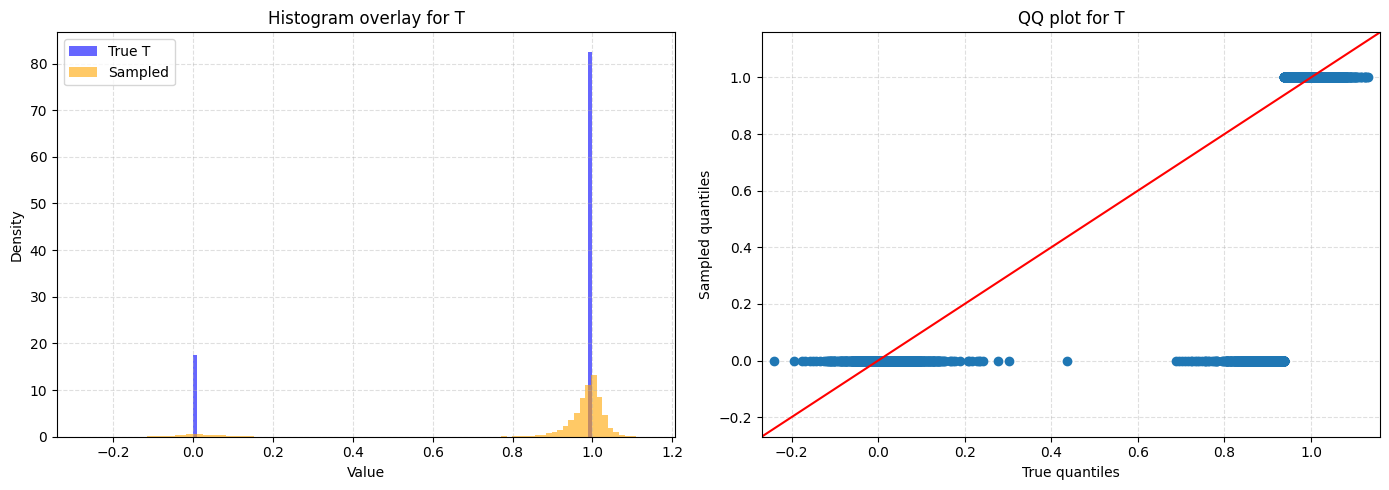

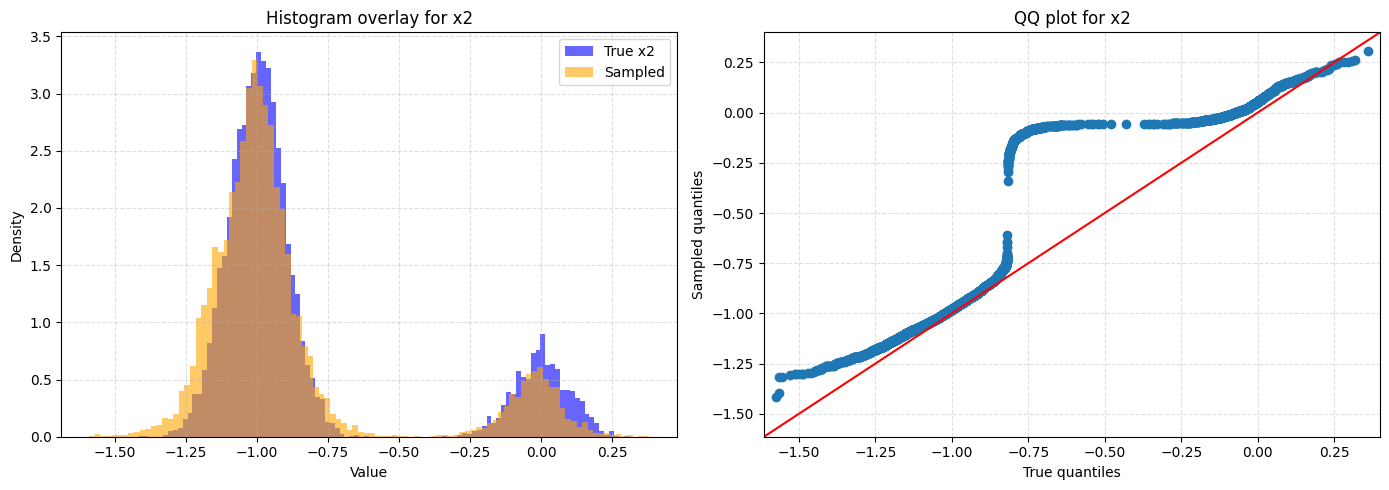

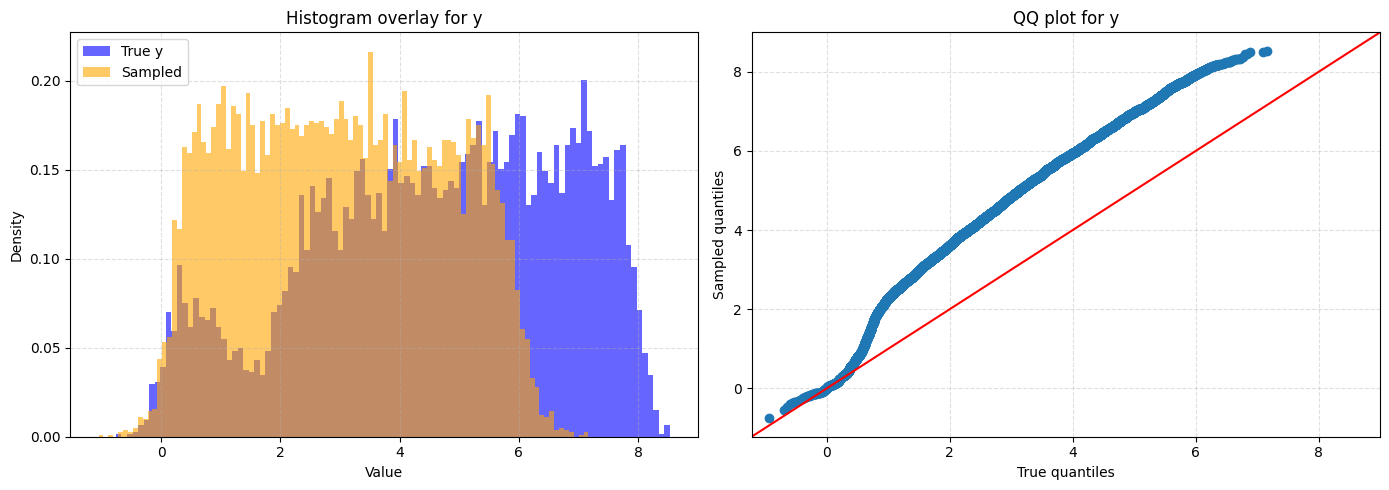

In [24]:
samples, latents = td_model.sample()
td_model.plot_samples_vs_true(train_df)

In [12]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp/min_max_scaling.json


In [15]:
u_training = td_model.get_latent(train_df)

[INFO] Final latent DataFrame shape: (8000, 8)


[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 8000
[INFO] Deleting all previously sampled data.
Deleted directory: exp/x1/sampling
Deleted directory: exp/T/sampling
Deleted directory: exp/x2/sampling
Deleted directory: exp/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U
[INFO] Loaded best model weights for node 'x1' from exp/x1/best_model.pt
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 60.68it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node T from dataframe column: T_U
[INFO] Loaded best model weights for node 'T' from exp/T/best_model.pt
[WARNING] target_col 'T' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 51.18it/s]

[INFO] Completed sampling for node 'T'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U
[INFO] Loaded best model weights for node 'x2' from exp/x2/best_model.pt
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 59.56it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U
[INFO] Loaded best model weights for node 'y' from exp/y/best_model.pt
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 58.99it/s]


[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


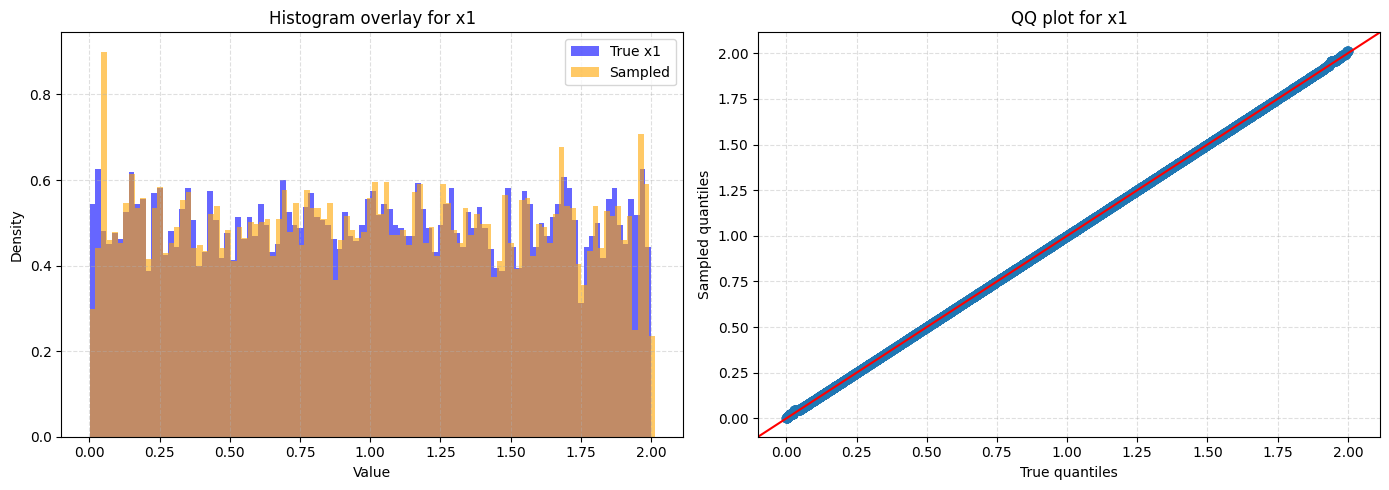

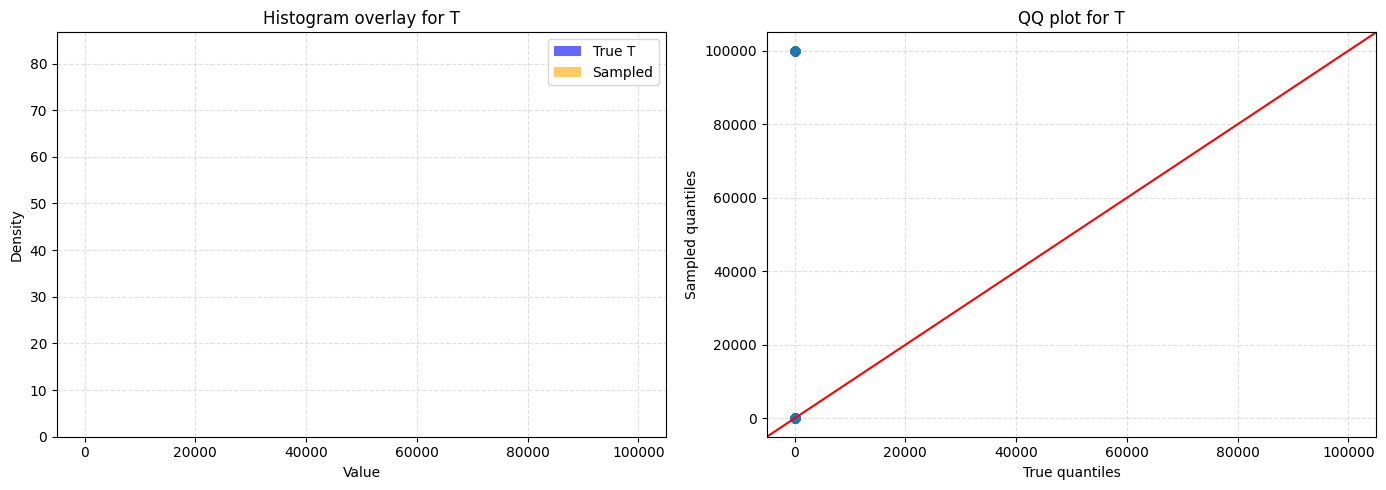

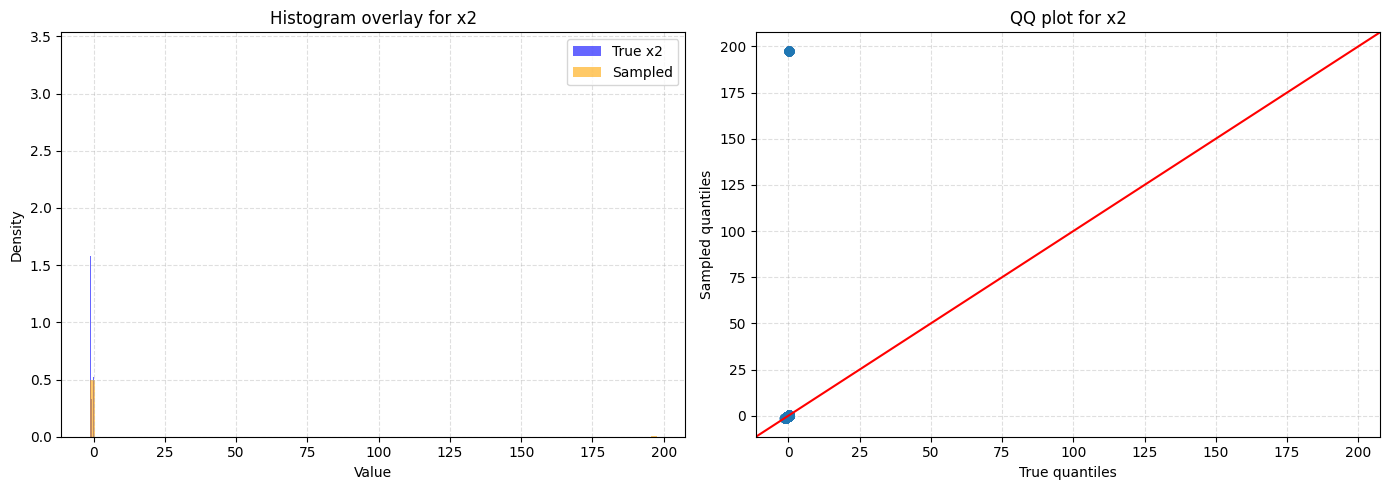

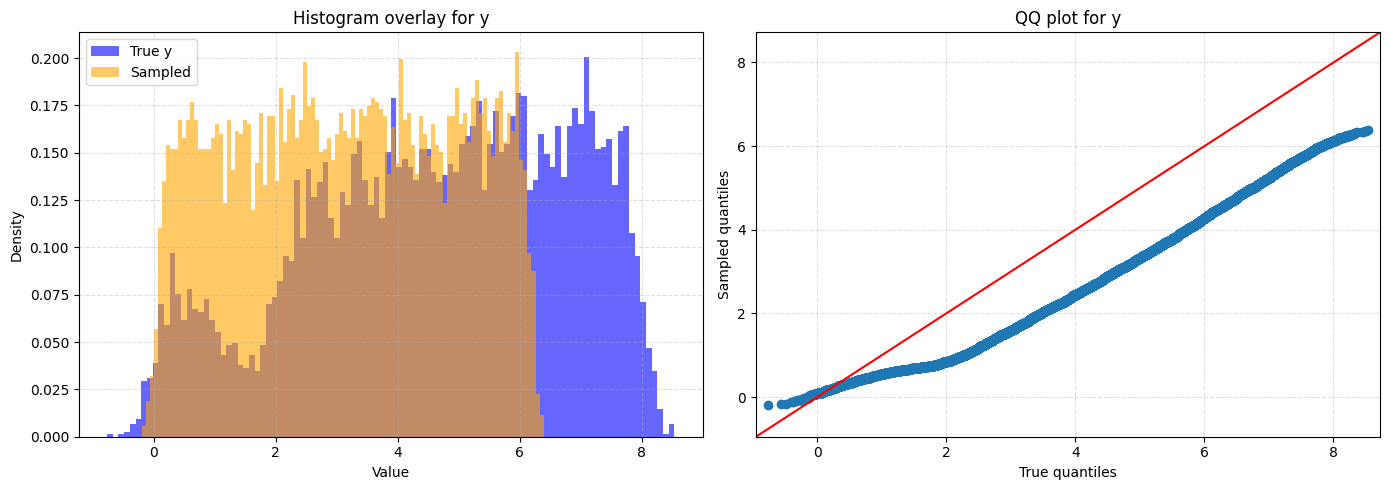

In [16]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_training)
# inter_df=dgp(n_obs=10_000, doX=[-1.0,None , None])
td_model.plot_samples_vs_true(train_df)

In [40]:
samples, latents = td_model.sample()

Deleted directory: exp/x1/sampling
Deleted directory: exp/T/sampling
Deleted directory: exp/x2/sampling
Deleted directory: exp/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 42.30it/s]


----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[WARNING] target_col 'T' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 40.89it/s]


----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.01it/s]


----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 42.88it/s]


In [39]:
u_training = td_model.get_latent(train_df)

[INFO] Final latent DataFrame shape: (800, 8)


In [ ]:
u_training.head()

In [ ]:
train_df.head()

In [25]:
# Make cross tab of T and x1
train_df['T']

29     1
535    0
695    1
557    1
836    1
      ..
106    1
270    1
860    1
435    0
102    1
Name: T, Length: 800, dtype: int64

In [14]:
############### !!!!!!!!!!!!!!!!!!!!!!!!! #######################################################
u_training = td_model.get_latent(train_df)
samples_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_training)
#################################################################################################

[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[INFO] Final latent DataFrame shape: (800, 8)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 800
[INFO] Deleting all previously sampled data.
Directory does not exist: exp/x1/sampling
Directory does not exist: exp/T/sampling
Directory does not exist: exp/x2/sampling
Directory does not exist: exp/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U
[WARNING] Best model not found for node 'x

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 340.79it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U
[WARNING] Best model not found for node 'x2'. Using initial weights instead.
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 347.44it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U
[WARNING] Best model not found for node 'y'. Using initial weights instead.
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 339.45it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


In [18]:
type(samples_doT1_with_T1)

pandas.core.frame.DataFrame

In [15]:
# Create a data frame from samples_doT1
samples_doT1_df = pd.DataFrame(samples_doT1)
print(samples_doT1_df.shape)
samples_doT1_df.head()
# Sahpe of samples_doT1_df
samples_doT1_df.shape, train_df.shape

# Extract the rows where T=1 from train_df and samples_doT1_df
mask = train_df['T'] == 1
train_with_T1 = train_df[mask]
samples_doT1_with_T1 = samples_doT1_df[mask.values]

train_with_T1.shape, samples_doT1_with_T1.shape
np.sum(train_with_T1['T'] == 1)
samples_doT1_with_T1['T']

(800, 4)


0      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
794    1.0
795    1.0
796    1.0
798    1.0
799    1.0
Name: T, Length: 675, dtype: float32

In [ ]:
np.mean(train_with_T1['T'] > 0.5)
samples_doT1_with_T1


np.float64(1.0)

In [28]:
train_with_T1['T']

29     1
695    1
557    1
836    1
596    1
      ..
700    1
106    1
270    1
860    1
102    1
Name: T, Length: 653, dtype: int64

In [17]:
import matplotlib.pyplot as plt

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

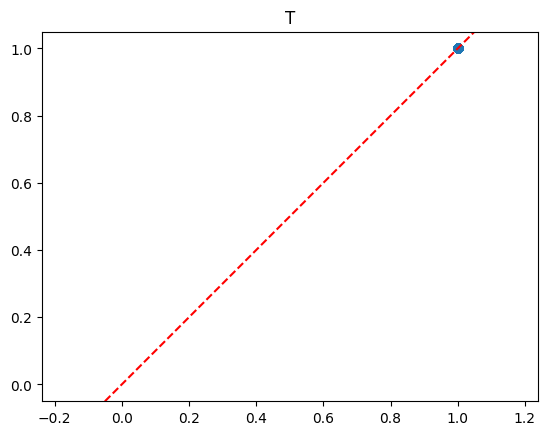

In [18]:
plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')

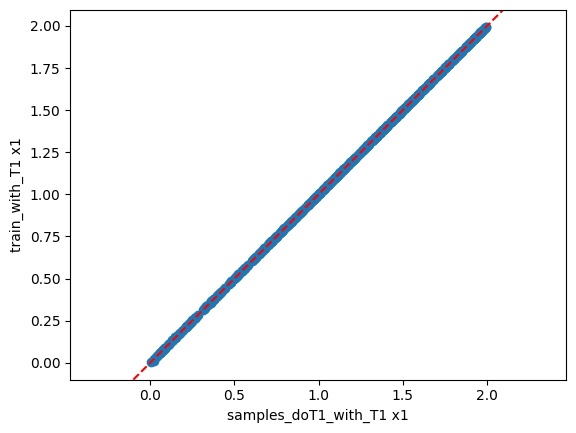

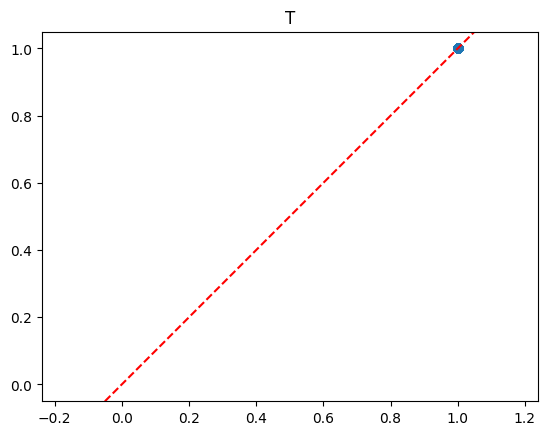

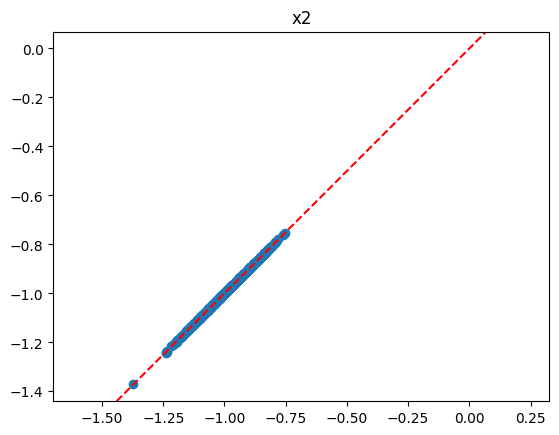

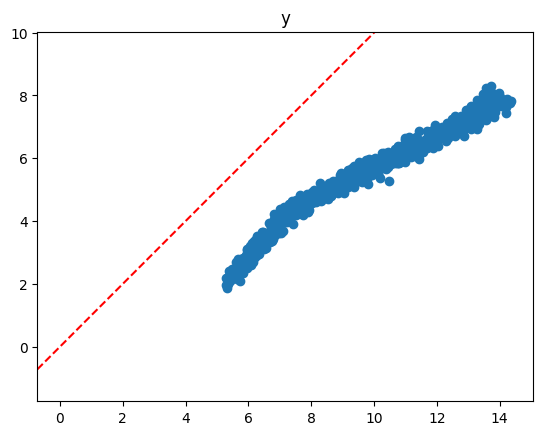

In [19]:
from matplotlib import pyplot as plt

plt.scatter(samples_doT1_with_T1['x1'], train_with_T1['x1'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.xlabel('samples_doT1_with_T1 x1')
plt.ylabel('train_with_T1 x1')
plt.show()


plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('x2')
plt.scatter(samples_doT1_with_T1['x2'], train_with_T1['x2'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('y')
plt.scatter(samples_doT1_with_T1['y'], train_with_T1['y'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()



In [ ]:
data_doT1